<a href="https://colab.research.google.com/github/BaichenTan/ExperimentData_Adv/blob/master/%E2%80%9CATE_Estimation_with_Machine_Learning_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ATT Estimation Tutorial

This tutorial gives a short example for how to estimate average treatment effect on the treated using machine learning methods

In [ ]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, log_loss
from xgboost import XGBClassifier, XGBRegressor
import sklearn
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import hist
from tabulate import tabulate

In [ ]:
RANDOM_SEED=42
np.random.seed(RANDOM_SEED)

# Import dataset

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/BaichenTan/ExperimentData_Adv/master/dataset_TRIMMED.csv")
data


,Unnamed: 0,followup_fallstudyhours,followup_getwritinghelp,followup_metwithinstructor,followup_metwithfreetutor,followup_imptodowellatuoft,followup_depressed,followup_stressed,fathers_education,mothers_education,fall_meangrade_year1,exp_gradschl,agreeableness2,agreeableness,extraversion2,extraversion,study_habit
0,1,5,5,5,1,6,1,2,4,5,66.00,1,1.794615,1,0.604456,1,11
1,2,6,4,2,0,6,0,0,2,1,80.50,0,-0.710559,0,-0.514052,0,6
2,3,1,1,0,0,5,2,2,3,8,51.00,1,1.023792,1,0.125096,1,1
3,4,11,4,5,0,6,1,2,6,6,86.00,1,0.060264,1,-1.952133,0,9
4,5,5,2,0,0,6,2,3,7,7,73.75,0,0.060264,1,0.444669,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048,1049,4,4,2,2,7,2,2,6,6,53.25,1,-0.325148,0,-0.194478,0,8
1049,1050,14,3,0,0,7,3,3,6,2,48.50,1,1.409204,1,-0.194478,0,3
1050,1051,6,3,1,1,5,2,2,0,0,66.00,0,0.638381,1,-0.673839,0,5
1051,1052,4,4,2,2,6,0,2,6,7,74.00,1,-1.674088,0,2.042537,1,8


## Counfounders, Outcome, and Treatment

In [ ]:
#create a dataset of confounders
confounders_without_Mediator = data[['fathers_education', 'mothers_education']]
confounders_with_allMediators = data[["followup_fallstudyhours", "followup_imptodowellatuoft", "followup_depressed", "followup_stressed", "fathers_education",	"mothers_education", "exp_gradschl", "study_habit"]]
confounders_with_mediatorStudyHours = data[["followup_fallstudyhours", "followup_imptodowellatuoft", "followup_depressed", "followup_stressed", "fathers_education",	"mothers_education", "exp_gradschl"]]
confounders_with_mediatorStudyHabits = data[["study_habit","followup_imptodowellatuoft", "followup_depressed", "followup_stressed", "fathers_education",	"mothers_education", "exp_gradschl"]]
outcome = data['fall_meangrade_year1']
treatment = data['extraversion']
placebo = data['agreeableness']

## Specify Nuisance Function Models

The next step is to specify models for the conditional expected outcome and propensity score

## Q model with randomforest

In [ ]:
# specify a model for the conditional expected outcome

# make a function that returns a sklearn model for later use in k-folding
def make_Qmodel_randomForest():
  return RandomForestRegressor(random_state=RANDOM_SEED, n_estimators=500, max_depth=None)

Qmodel_randomForest = make_Qmodel_randomForest()

# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

## Q model with linear regression

In [ ]:
def make_Qmodel_linearRegression():
  return LinearRegression()

Qmodel_LinearRegression = make_Qmodel_linearRegression()



## Q model with XGBoost 

In [ ]:
def make_Qmodel_XGBoost():
  return XGBRegressor(n_jobs=1, objective = "reg:squarederror", random_state=RANDOM_SEED)

Qmodel_XGBRegressor = make_Qmodel_XGBoost()

## Sanity Check for various confounder conditions

### Sanity Check for RandomForest Model

#### Sanity Check for confounders without Mediators

In [ ]:
Qmodel_randomForest = make_Qmodel_randomForest()

# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

X_w_treatment = confounders_without_Mediator.copy()
X_w_treatment["treatment"] = treatment

X_train, X_test, y_train, y_test = train_test_split(X_w_treatment, outcome, test_size=0.2)
Qmodel_randomForest.fit(X_train, y_train)
y_pred = Qmodel_randomForest.predict(X_test)

test_mse_RF0=mean_squared_error(y_pred, y_test)
print(f"Test MSE of fit model {test_mse_RF0}") 
baseline_mse_RF0=mean_squared_error(y_train.mean()*np.ones_like(y_test), y_test)
print(f"Test MSE of no-covariate model {baseline_mse_RF0}")

Test MSE of fit model 144.6025573445408
Test MSE of no-covariate model 132.34096825182152


#### Sanity Check for confounders with both Mediators

In [ ]:
Qmodel_randomForest = make_Qmodel_randomForest()

# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

X_w_treatment = confounders_with_allMediators.copy()
X_w_treatment["treatment"] = treatment

X_train, X_test, y_train, y_test = train_test_split(X_w_treatment, outcome, test_size=0.2)
Qmodel_randomForest.fit(X_train, y_train)
y_pred = Qmodel_randomForest.predict(X_test)

test_mse_RF2=mean_squared_error(y_pred, y_test)
print(f"Test MSE of fit model {test_mse_RF2}") 
baseline_mse_RF2=mean_squared_error(y_train.mean()*np.ones_like(y_test), y_test)
print(f"Test MSE of no-covariate model {baseline_mse_RF2}")

Test MSE of fit model 151.76551837794443
Test MSE of no-covariate model 138.7781499254707


#### Sanity Check for confounders with just one Mediator StudyHours

In [ ]:
Qmodel_randomForest = make_Qmodel_randomForest()

# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

X_w_treatment = confounders_with_mediatorStudyHours.copy()
X_w_treatment["treatment"] = treatment

X_train, X_test, y_train, y_test = train_test_split(X_w_treatment, outcome, test_size=0.2)
Qmodel_randomForest.fit(X_train, y_train)
y_pred = Qmodel_randomForest.predict(X_test)

test_mse_RFSH=mean_squared_error(y_pred, y_test)
print(f"Test MSE of fit model {test_mse_RFSH}") 
baseline_mse_RFSH=mean_squared_error(y_train.mean()*np.ones_like(y_test), y_test)
print(f"Test MSE of no-covariate model {baseline_mse_RFSH}")

Test MSE of fit model 165.08544539862348
Test MSE of no-covariate model 163.85426183110812


#### Sanity Check for confounders with just one Mediator StudyHabits

In [ ]:
Qmodel_randomForest = make_Qmodel_randomForest()

# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

X_w_treatment = confounders_with_mediatorStudyHabits.copy()
X_w_treatment["treatment"] = treatment

X_train, X_test, y_train, y_test = train_test_split(X_w_treatment, outcome, test_size=0.2)
Qmodel_randomForest.fit(X_train, y_train)
y_pred = Qmodel_randomForest.predict(X_test)

test_mse_RFSB=mean_squared_error(y_pred, y_test)
print(f"Test MSE of fit model {test_mse_RFSB}") 
baseline_mse_RFSB=mean_squared_error(y_train.mean()*np.ones_like(y_test), y_test)
print(f"Test MSE of no-covariate model {baseline_mse_RFSB}")

Test MSE of fit model 157.8912658856867
Test MSE of no-covariate model 140.98459052997688


### Sanity Check for Logistic Regression

Sanity Check for counfounders without Mediators

In [ ]:
Qmodel_LinearRegression = make_Qmodel_linearRegression()

# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

X_w_treatment = confounders_without_Mediator.copy()
X_w_treatment["treatment"] = treatment

X_train, X_test, y_train, y_test = train_test_split(X_w_treatment, outcome, test_size=0.2)
Qmodel_LinearRegression.fit(X_train, y_train)
y_pred1 = Qmodel_LinearRegression.predict(X_test)

test_mse_LR0=mean_squared_error(y_pred1, y_test)
print(f"Test MSE of fit model {test_mse_LR0}") 
baseline_mse_LR0=mean_squared_error(y_train.mean()*np.ones_like(y_test), y_test)
print(f"Test MSE of no-covariate model {baseline_mse_LR0}")

Test MSE of fit model 128.83520191287093
Test MSE of no-covariate model 129.30311703806595


Sanity Check for confounders with both Mediators

In [ ]:
Qmodel_LinearRegression = make_Qmodel_linearRegression()

# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

X_w_treatment = confounders_with_allMediators.copy()
X_w_treatment["treatment"] = treatment

X_train, X_test, y_train, y_test = train_test_split(X_w_treatment, outcome, test_size=0.2)
Qmodel_LinearRegression.fit(X_train, y_train)
y_pred1 = Qmodel_LinearRegression.predict(X_test)

test_mse_LR2=mean_squared_error(y_pred1, y_test)
print(f"Test MSE of fit model {test_mse_LR2}") 
baseline_mse_LR2=mean_squared_error(y_train.mean()*np.ones_like(y_test), y_test)
print(f"Test MSE of no-covariate model {baseline_mse_LR2}")

Test MSE of fit model 146.29214126301753
Test MSE of no-covariate model 158.2825105729674


Sanity Check for confounders with just one Mediator StudyHours

In [ ]:
Qmodel_LinearRegression = make_Qmodel_linearRegression()

# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

X_w_treatment = confounders_with_mediatorStudyHours.copy()
X_w_treatment["treatment"] = treatment

X_train, X_test, y_train, y_test = train_test_split(X_w_treatment, outcome, test_size=0.2)
Qmodel_LinearRegression.fit(X_train, y_train)
y_pred1 = Qmodel_LinearRegression.predict(X_test)

test_mse_LRSH=mean_squared_error(y_pred1, y_test)
print(f"Test MSE of fit model {test_mse_LRSH}") 
baseline_mse_LRSH=mean_squared_error(y_train.mean()*np.ones_like(y_test), y_test)
print(f"Test MSE of no-covariate model {baseline_mse_LRSH}")

Test MSE of fit model 142.28820463484635
Test MSE of no-covariate model 149.31923245486362


Sanity Check for confounders with just one Mediator StudyHabits

In [ ]:
Qmodel_LinearRegression = make_Qmodel_linearRegression()

# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

X_w_treatment = confounders_with_mediatorStudyHabits.copy()
X_w_treatment["treatment"] = treatment

X_train, X_test, y_train, y_test = train_test_split(X_w_treatment, outcome, test_size=0.2)
Qmodel_LinearRegression.fit(X_train, y_train)
y_pred1 = Qmodel_LinearRegression.predict(X_test)

test_mse_LRSB=mean_squared_error(y_pred1, y_test)
print(f"Test MSE of fit model {test_mse_LRSB}") 
baseline_mse_LRSB=mean_squared_error(y_train.mean()*np.ones_like(y_test), y_test)
print(f"Test MSE of no-covariate model {baseline_mse_LRSB}")

Test MSE of fit model 144.78312111807816
Test MSE of no-covariate model 148.9840110356087


### Sanity Check for XGBoost Model

Sanity Check for counfounders without Mediators

In [ ]:
Qmodel_XGBoost = make_Qmodel_XGBoost()

# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

X_w_treatment = confounders_without_Mediator.copy()
X_w_treatment["treatment"] = treatment

X_train, X_test, y_train, y_test = train_test_split(X_w_treatment, outcome, test_size=0.2)
Qmodel_XGBoost.fit(X_train, y_train)
y_pred1 = Qmodel_XGBoost.predict(X_test)

test_mse_XG0=mean_squared_error(y_pred1, y_test)
print(f"Test MSE of fit model {test_mse_XG0}") 
baseline_mse_XG0=mean_squared_error(y_train.mean()*np.ones_like(y_test), y_test)
print(f"Test MSE of no-covariate model {baseline_mse_XG0}")

Test MSE of fit model 146.8405555905983
Test MSE of no-covariate model 142.85195264345685


Sanity Check for confounders with both Mediators

In [ ]:
Qmodel_XGBoost = make_Qmodel_XGBoost()

# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

X_w_treatment = confounders_with_allMediators.copy()
X_w_treatment["treatment"] = treatment

X_train, X_test, y_train, y_test = train_test_split(X_w_treatment, outcome, test_size=0.2)
Qmodel_XGBoost.fit(X_train, y_train)
y_pred1 = Qmodel_XGBoost.predict(X_test)

test_mse_XG2=mean_squared_error(y_pred1, y_test)
print(f"Test MSE of fit model {test_mse_XG2}") 
baseline_mse_XG2=mean_squared_error(y_train.mean()*np.ones_like(y_test), y_test)
print(f"Test MSE of no-covariate model {baseline_mse_XG2}")

Test MSE of fit model 136.0710437860533
Test MSE of no-covariate model 127.67333638973136


Sanity Check for confounders with just one Mediator StudyHours

In [ ]:
Qmodel_XGBoost = make_Qmodel_XGBoost()

# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

X_w_treatment = confounders_with_mediatorStudyHours.copy()
X_w_treatment["treatment"] = treatment

X_train, X_test, y_train, y_test = train_test_split(X_w_treatment, outcome, test_size=0.2)
Qmodel_XGBoost.fit(X_train, y_train)
y_pred1 = Qmodel_XGBoost.predict(X_test)

test_mse_XGSH=mean_squared_error(y_pred1, y_test)
print(f"Test MSE of fit model {test_mse_XGSH}") 
baseline_mse_XGSH=mean_squared_error(y_train.mean()*np.ones_like(y_test), y_test)
print(f"Test MSE of no-covariate model {baseline_mse_XGSH}")

Test MSE of fit model 171.7909680989912
Test MSE of no-covariate model 178.13661746081732


Sanity Check for confounders with just one Mediator StudyHabits

In [ ]:
Qmodel_XGBoost = make_Qmodel_XGBoost()

# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

X_w_treatment = confounders_with_mediatorStudyHabits.copy()
X_w_treatment["treatment"] = treatment

X_train, X_test, y_train, y_test = train_test_split(X_w_treatment, outcome, test_size=0.2)
Qmodel_XGBoost.fit(X_train, y_train)
y_pred1 = Qmodel_XGBoost.predict(X_test)

test_mse_XGSB=mean_squared_error(y_pred1, y_test)
print(f"Test MSE of fit model {test_mse_XGSB}") 
baseline_mse_XGSB=mean_squared_error(y_train.mean()*np.ones_like(y_test), y_test)
print(f"Test MSE of no-covariate model {baseline_mse_XGSB}")

Test MSE of fit model 117.64240187478954
Test MSE of no-covariate model 120.11981962739856


## g model

### g model with RandomForest

In [ ]:
# specify a model for the propensity score

def make_gmodel_randomForest():

  return RandomForestClassifier(n_estimators=100, max_depth=5)

gmodel_randomForest = make_gmodel_randomForest()
# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 
'''
# Sanity check of confounders with mediators
X_train, X_test, a_train, a_test = train_test_split(confounders_with_Mediators, treatment, test_size=0.2)
gmodel.fit(X_train, a_train)
a_pred = gmodel.predict_proba(X_test)[:,1]

test_ce=log_loss(a_test, a_pred)
print(f"Test CE of fit model {test_ce}") 
baseline_ce=log_loss(a_test, a_train.mean()*np.ones_like(a_test))
print(f"Test CE of no-covariate model {baseline_ce}")
'''

'\n# Sanity check of confounders with mediators\nX_train, X_test, a_train, a_test = train_test_split(confounders_with_Mediators, treatment, test_size=0.2)\ngmodel.fit(X_train, a_train)\na_pred = gmodel.predict_proba(X_test)[:,1]\n\ntest_ce=log_loss(a_test, a_pred)\nprint(f"Test CE of fit model {test_ce}") \nbaseline_ce=log_loss(a_test, a_train.mean()*np.ones_like(a_test))\nprint(f"Test CE of no-covariate model {baseline_ce}")\n'

## g model with logistic regression

In [ ]:
def make_gmodel_logisticRegression():
  return LogisticRegression(max_iter=1000)

gmodel_LogisticRegression = make_gmodel_logisticRegression()

## g model with XGBoost

In [ ]:
def make_gmodel_XGBClassifier():
  return XGBClassifier(use_label_encoder=False, n_jobs=1, objective='binary:logistic',eval_metric = 'logloss', random_state =RANDOM_SEED)

gmodel_XGBClassifier = make_gmodel_XGBClassifier()

## Sanity Check for Various Confounding Conditions

### Sanity Check for RandomForest Model

#### Sanity Check for confounders without Mediators

In [ ]:
gmodel_randomForest = make_gmodel_randomForest()
# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

# Sanity check of confounders with mediators
X_train, X_test, a_train, a_test = train_test_split(confounders_without_Mediator, treatment, test_size=0.2)
gmodel_randomForest.fit(X_train, a_train)
a_pred = gmodel_randomForest.predict_proba(X_test)[:,1]

test_ce_RF0=log_loss(a_test, a_pred)
print(f"Test CE of fit model {test_ce_RF0}") 
baseline_ce_RF0=log_loss(a_test, a_train.mean()*np.ones_like(a_test))
print(f"Test CE of no-covariate model {baseline_ce_RF0}")

Test CE of fit model 0.7013706057844085
Test CE of no-covariate model 0.6931471805599453


#### Sanity Check for confounders with both Mediators

In [ ]:
gmodel_randomForest = make_gmodel_randomForest()
# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

# Sanity check of confounders with mediators
X_train, X_test, a_train, a_test = train_test_split(confounders_with_allMediators, treatment, test_size=0.2)
gmodel_randomForest.fit(X_train, a_train)
a_pred = gmodel_randomForest.predict_proba(X_test)[:,1]

test_ce_RF2=log_loss(a_test, a_pred)
print(f"Test CE of fit model {test_ce_RF2}") 
baseline_ce_RF2=log_loss(a_test, a_train.mean()*np.ones_like(a_test))
print(f"Test CE of no-covariate model {baseline_ce_RF2}")

Test CE of fit model 0.7070381116421837
Test CE of no-covariate model 0.6931471805599453


#### Sanity Check for confounders with just one Mediator StudyHours

In [ ]:
gmodel_randomForest = make_gmodel_randomForest()
# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

# Sanity check of confounders with mediators
X_train, X_test, a_train, a_test = train_test_split(confounders_with_mediatorStudyHours, treatment, test_size=0.2)
gmodel_randomForest.fit(X_train, a_train)
a_pred = gmodel_randomForest.predict_proba(X_test)[:,1]

test_ce_RFSH=log_loss(a_test, a_pred)
print(f"Test CE of fit model {test_ce_RFSH}") 
baseline_ce_RFSH=log_loss(a_test, a_train.mean()*np.ones_like(a_test))
print(f"Test CE of no-covariate model {baseline_ce_RFSH}")

Test CE of fit model 0.6952597045037472
Test CE of no-covariate model 0.693770551837665


#### Sanity Check for confounders with just one Mediator StudyHabits

In [ ]:
gmodel_randomForest = make_gmodel_randomForest()
# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

# Sanity check of confounders with mediators
X_train, X_test, a_train, a_test = train_test_split(confounders_with_mediatorStudyHabits, treatment, test_size=0.2)
gmodel_randomForest.fit(X_train, a_train)
a_pred = gmodel_randomForest.predict_proba(X_test)[:,1]

test_ce_RFSB=log_loss(a_test, a_pred)
print(f"Test CE of fit model {test_ce_RFSB}") 
baseline_ce_RFSB=log_loss(a_test, a_train.mean()*np.ones_like(a_test))
print(f"Test CE of no-covariate model {baseline_ce_RFSB}")

Test CE of fit model 0.6899995603331717
Test CE of no-covariate model 0.6924185351327965


### Sanity Check for Logistic Regression

#### Sanity Check for confounders without Mediators

In [ ]:
gmodel_LogisticRegression = make_gmodel_logisticRegression()
# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

# Sanity check of confounders with mediators
X_train, X_test, a_train, a_test = train_test_split(confounders_without_Mediator, treatment, test_size=0.2)
gmodel_LogisticRegression.fit(X_train, a_train)
a_pred = gmodel_LogisticRegression.predict_proba(X_test)[:,1]

test_ce_LR0=log_loss(a_test, a_pred)
print(f"Test CE of fit model {test_ce_LR0}") 
baseline_ce_LR0=log_loss(a_test, a_train.mean()*np.ones_like(a_test))
print(f"Test CE of no-covariate model {baseline_ce_LR0}")

Test CE of fit model 0.6857449040981308
Test CE of no-covariate model 0.6928663894825309


#### Sanity Check for confounders with both Mediators

In [ ]:
gmodel_LogisticRegression = make_gmodel_logisticRegression()
# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

# Sanity check of confounders with mediators
X_train, X_test, a_train, a_test = train_test_split(confounders_with_allMediators, treatment, test_size=0.2)
gmodel_LogisticRegression.fit(X_train, a_train)
a_pred = gmodel_LogisticRegression.predict_proba(X_test)[:,1]

test_ce_LR2=log_loss(a_test, a_pred)
print(f"Test CE of fit model {test_ce_LR2}") 
baseline_ce_LR2=log_loss(a_test, a_train.mean()*np.ones_like(a_test))
print(f"Test CE of no-covariate model {baseline_ce_LR2}")

Test CE of fit model 0.7047753332786164
Test CE of no-covariate model 0.6923733714269587


#### Sanity Check for confounders with just one Mediator StudyHours

In [ ]:
gmodel_LogisticRegression = make_gmodel_logisticRegression()
# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

# Sanity check of confounders with mediators
X_train, X_test, a_train, a_test = train_test_split(confounders_with_mediatorStudyHours, treatment, test_size=0.2)
gmodel_LogisticRegression.fit(X_train, a_train)
a_pred = gmodel_LogisticRegression.predict_proba(X_test)[:,1]

test_ce_LRSH=log_loss(a_test, a_pred)
print(f"Test CE of fit model {test_ce_LRSH}") 
baseline_ce_LRSH=log_loss(a_test, a_train.mean()*np.ones_like(a_test))
print(f"Test CE of no-covariate model {baseline_ce_LRSH}")

Test CE of fit model 0.6872943011459524
Test CE of no-covariate model 0.6934184476415775


#### Sanity Check for confounders with just one Mediator StudyHabits

In [ ]:
gmodel_LogisticRegression = make_gmodel_logisticRegression()
# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

# Sanity check of confounders with mediators
X_train, X_test, a_train, a_test = train_test_split(confounders_with_mediatorStudyHabits, treatment, test_size=0.2)
gmodel_LogisticRegression.fit(X_train, a_train)
a_pred = gmodel_LogisticRegression.predict_proba(X_test)[:,1]

test_ce_LRSB=log_loss(a_test, a_pred)
print(f"Test CE of fit model {test_ce_LRSB}") 
baseline_ce_LRSB=log_loss(a_test, a_train.mean()*np.ones_like(a_test))
print(f"Test CE of no-covariate model {baseline_ce_LRSB}")

Test CE of fit model 0.681075615964001
Test CE of no-covariate model 0.6923706162117814


### Sanity Check for XGBoost Model

#### Sanity Check for confounders without Mediators

In [ ]:
gmodel_XGBClassifier = make_gmodel_XGBClassifier()
# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

# Sanity check of confounders with mediators
X_train, X_test, a_train, a_test = train_test_split(confounders_without_Mediator, treatment, test_size=0.2)
gmodel_XGBClassifier.fit(X_train, a_train)
a_pred = gmodel_XGBClassifier.predict_proba(X_test)[:,1]

test_ce_XG0=log_loss(a_test, a_pred)
print(f"Test CE of fit model {test_ce_XG0}") 
baseline_ce_XG0=log_loss(a_test, a_train.mean()*np.ones_like(a_test))
print(f"Test CE of no-covariate model {baseline_ce_XG0}")

Test CE of fit model 0.7166135618330743
Test CE of no-covariate model 0.6956864288217224


#### Sanity Check for confounders with both Mediators

In [ ]:
gmodel_XGBClassifier = make_gmodel_XGBClassifier()
# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

# Sanity check of confounders with mediators
X_train, X_test, a_train, a_test = train_test_split(confounders_with_allMediators, treatment, test_size=0.2)
gmodel_XGBClassifier.fit(X_train, a_train)
a_pred = gmodel_XGBClassifier.predict_proba(X_test)[:,1]

test_ce_XG2=log_loss(a_test, a_pred)
print(f"Test CE of fit model {test_ce_XG2}") 
baseline_ce_XG2=log_loss(a_test, a_train.mean()*np.ones_like(a_test))
print(f"Test CE of no-covariate model {baseline_ce_XG2}")

Test CE of fit model 0.7425388511605737
Test CE of no-covariate model 0.6962923380167392


#### Sanity Check for confounders with just one Mediator StudyHours

In [ ]:
gmodel_XGBClassifier = make_gmodel_XGBClassifier()
# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

# Sanity check of confounders with mediators
X_train, X_test, a_train, a_test = train_test_split(confounders_with_mediatorStudyHours, treatment, test_size=0.2)
gmodel_XGBClassifier.fit(X_train, a_train)
a_pred = gmodel_XGBClassifier.predict_proba(X_test)[:,1]

test_ce_XGSH=log_loss(a_test, a_pred)
print(f"Test CE of fit model {test_ce_XGSH}") 
baseline_ce_XGSH=log_loss(a_test, a_train.mean()*np.ones_like(a_test))
print(f"Test CE of no-covariate model {baseline_ce_XGSH}")

Test CE of fit model 0.7259747396925049
Test CE of no-covariate model 0.692517132862487


#### Sanity Check for confounders with just one Mediator StudyHabits

In [ ]:
gmodel_XGBClassifier = make_gmodel_XGBClassifier()
# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

# Sanity check of confounders with mediators
X_train, X_test, a_train, a_test = train_test_split(confounders_with_mediatorStudyHabits, treatment, test_size=0.2)
gmodel_XGBClassifier.fit(X_train, a_train)
a_pred = gmodel_XGBClassifier.predict_proba(X_test)[:,1]

test_ce_XGSB=log_loss(a_test, a_pred)
print(f"Test CE of fit model {test_ce_XGSB}") 
baseline_ce_XGSB=log_loss(a_test, a_train.mean()*np.ones_like(a_test))
print(f"Test CE of no-covariate model {baseline_ce_XGSB}")

Test CE of fit model 0.7599684692107106
Test CE of no-covariate model 0.6931170637648454


## Use cross fitting to get get predicted outcomes and propensity scores for each unit

In [ ]:
# helper functions to implement the cross fitting

def treatment_k_fold_fit_and_predict(make_model, X:pd.DataFrame, A:np.array, n_splits:int):
    """
    Implements K fold cross-fitting for the model predicting the treatment A. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns an array containing the predictions  

    Args:
    model: function that returns sklearn model (which implements fit and predict_prob)
    X: dataframe of variables to adjust for
    A: array of treatments
    n_splits: number of splits to use
    """
    predictions = np.full_like(A, np.nan, dtype=float)
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    
    for train_index, test_index in kf.split(X, A):
      X_train = X.loc[train_index]
      A_train = A.loc[train_index]
      g = make_model()
      g.fit(X_train, A_train)

      # get predictions for split
      predictions[test_index] = g.predict_proba(X.loc[test_index])[:, 1]

    assert np.isnan(predictions).sum() == 0
    return predictions


def outcome_k_fold_fit_and_predict(make_model, X:pd.DataFrame, y:np.array, A:np.array, n_splits:int, output_type:str):
    """
    Implements K fold cross-fitting for the model predicting the outcome Y. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns two arrays containing the predictions for all units untreated, all units treated  

    Args:
    model: function that returns sklearn model (that implements fit and either predict_prob or predict)
    X: dataframe of variables to adjust for
    y: array of outcomes
    A: array of treatments
    n_splits: number of splits to use
    output_type: type of outcome, "binary" or "continuous"

    """
    predictions0 = np.full_like(A, np.nan, dtype=float)
    predictions1 = np.full_like(y, np.nan, dtype=float)
    if output_type == 'binary':
      kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    elif output_type == 'continuous':
      kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

    # include the treatment as input feature
    X_w_treatment = X.copy()
    X_w_treatment["A"] = A

    # for predicting effect under treatment / control status for each data point 
    X0 = X_w_treatment.copy()
    X0["A"] = 0
    X1 = X_w_treatment.copy()
    X1["A"] = 1

    
    for train_index, test_index in kf.split(X_w_treatment, y):
      X_train = X_w_treatment.loc[train_index]
      y_train = y.loc[train_index]
      q = make_model()
      q.fit(X_train, y_train)

      if output_type =='binary':
        predictions0[test_index] = q.predict_proba(X0.loc[test_index])[:, 1]
        predictions1[test_index] = q.predict_proba(X1.loc[test_index])[:, 1]
      elif output_type == 'continuous':
        predictions0[test_index] = q.predict(X0.loc[test_index])
        predictions1[test_index] = q.predict(X1.loc[test_index])

    assert np.isnan(predictions0).sum() == 0
    assert np.isnan(predictions1).sum() == 0
    return predictions0, predictions1

## Combine predicted values and data into estimate of ATU

In [ ]:
def att_aiptw(Q0, Q1, g, A, Y, prob_t=None):
  """
  # Double ML estimator for the ATT
  This uses the ATT specific scores, see equation 3.9 of https://www.econstor.eu/bitstream/10419/149795/1/869216953.pdf
  """

  if prob_t is None:
    prob_t = 1 - A.mean() # estimate marginal probability of treatment

  tau_hat = (A*((1-g)/g)*(Y-Q1) - (1-A)*(Y-Q1)).mean()/ prob_t
  
  scores = (A*((1-g)/g)*(Y-Q1) - (1-A)*(Y-Q1) - tau_hat*(1-A)) / prob_t
  n = Y.shape[0] # number of observations
  std_hat = np.std(scores) / np.sqrt(n)

  return tau_hat, std_hat


In [ ]:
def ate_aiptw(Q0, Q1, g, A, Y, prob_t=None):
  """
  # Double ML estimator for the ATE
  """

  tau_hat = (Q1 - Q0 + A*(Y-Q1)/g - (1-A)*(Y-Q0)/(1-g)).mean()
  
  scores = Q1 - Q0 + A*(Y-Q1)/g - (1-A)*(Y-Q0)/(1-g) - tau_hat
  n = Y.shape[0] # number of observations
  std_hat = np.std(scores) / np.sqrt(n)

  return tau_hat, std_hat


# Natural Direct Effect with two Mediators

## Check Overlap Conditions 0<Pr(A =1 |𝐗 = x, M1 = m1, M2 = m2) < 1 using the three models

Text(0.5, 1.0, 'Using RandomForest')

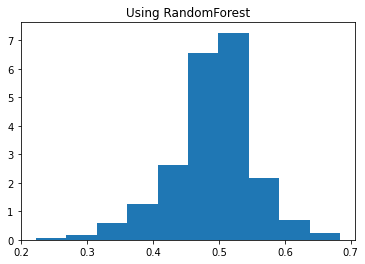

In [ ]:
#check the ovrlap conditions using randomForest
#get the propensity score function
g1 = treatment_k_fold_fit_and_predict(make_gmodel_randomForest, X=confounders_with_allMediators, A=treatment, n_splits=10)
hist(g1, density=True)
plt.title("Using RandomForest")


(array([0.07835569, 0.11753354, 0.80314584, 2.42902645, 4.81887506,
        5.81791013, 4.07449598, 1.86094769, 0.54848984, 0.07835569]),
 array([0.22794654, 0.27642637, 0.32490619, 0.37338602, 0.42186585,
        0.47034568, 0.51882551, 0.56730533, 0.61578516, 0.66426499,
        0.71274482]),
 <a list of 10 Patch objects>)

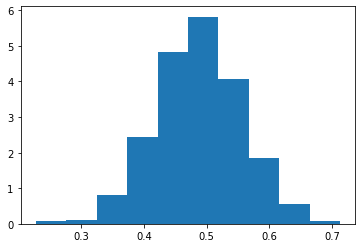

In [ ]:
#check the ovrlap conditions using Logistic Regression
g2 = treatment_k_fold_fit_and_predict(make_gmodel_logisticRegression, X=confounders_with_allMediators, A=treatment, n_splits=10)
hist(g2, density=True)

(array([0.10131624, 0.23640456, 0.81052992, 1.33962585, 2.39781769,
        3.59109786, 2.31901617, 0.6191548 , 0.38275024, 0.0562868 ]),
 array([0.05263337, 0.13699308, 0.22135279, 0.3057125 , 0.39007221,
        0.47443192, 0.55879162, 0.64315133, 0.72751104, 0.81187075,
        0.89623046]),
 <a list of 10 Patch objects>)

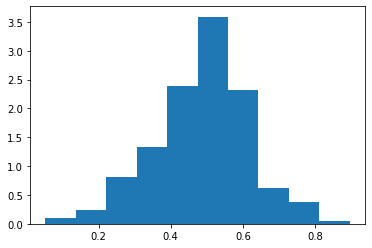

In [ ]:
#check the ovrlap conditions using XGBoost
g3 = treatment_k_fold_fit_and_predict(make_gmodel_XGBClassifier, X=confounders_with_allMediators, A=treatment, n_splits=10)
hist(g3, density=True)

## Calculate Natural Direct Effect with two mediators using RandomForest

### Calculate Q0 and Q1 model using Random Forest

In [ ]:
#calculate Q0 and Q1 model
Q0_RF,Q1_RF = outcome_k_fold_fit_and_predict(make_Qmodel_randomForest, X=confounders_with_allMediators, y=outcome, A=treatment, n_splits=10, output_type="continuous")

### Combine the Dataset for g, Q0, Q1, A, and Y values

In [ ]:
data_and_nuisance_estimates_RF = pd.DataFrame({'g': g1, 'Q0': Q0_RF, 'Q1': Q1_RF, 'A': treatment, 'Y': outcome})
data_and_nuisance_estimates_RF.head()

,g,Q0,Q1,A,Y
0,0.519652,66.439667,65.437567,1,66.00
1,0.298907,74.915100,68.655400,0,80.50
2,0.236894,63.706833,64.287100,1,51.00
3,0.545938,67.958000,67.872850,0,86.00
4,0.486108,69.538967,69.495800,1,73.75


### Calculate the Natural Direct Effect using the ATU formula

In [ ]:
tau_hat_RF, std_hat_RF = att_aiptw(**data_and_nuisance_estimates_RF)
print(f"The estimate using RandomForest is {tau_hat_RF} pm {1.96*std_hat_RF}")

The estimate using RandomForest is -2.638443330772566 pm 1.5277293563941472


## Calculate Natural Direct Effect with two mediators using Logistic Regression

### Calculate Q0 and Q1 model using Logistic Regression

In [ ]:
Q0_LR,Q1_LR = outcome_k_fold_fit_and_predict(make_Qmodel_linearRegression, X=confounders_with_allMediators, y=outcome, A=treatment, n_splits=10, output_type="continuous")

### Combine the dataset for g, Q0, Q1, A, and Y values

In [ ]:
data_and_nuisance_estimates_LR = pd.DataFrame({'g': g2, 'Q0': Q0_LR, 'Q1': Q1_LR, 'A': treatment, 'Y': outcome})
data_and_nuisance_estimates_LR.head()

,g,Q0,Q1,A,Y
0,0.578911,70.992020,69.441309,1,66.00
1,0.326688,70.598015,68.632287,0,80.50
2,0.559670,68.463686,66.537179,1,51.00
3,0.533289,73.474415,71.547909,0,86.00
4,0.542145,69.201397,67.557448,1,73.75


### Calculate the Natural Direct Effect using the ATU formula

In [ ]:
tau_hat_LR, std_hat_LR = att_aiptw(**data_and_nuisance_estimates_LR)
print(f"The estimate using RandomForest is {tau_hat_LR} pm {1.96*std_hat_LR}")

The estimate using RandomForest is -1.8927439609517929 pm 1.4628057414180229


## Calculate the Natural Direct Effect with two Mediators using XGBoost model

### Calculate Q0 and Q1 model using XGBoost

In [ ]:
Q0_XGB,Q1_XGB = outcome_k_fold_fit_and_predict(make_Qmodel_XGBoost, X=confounders_with_allMediators, y=outcome, A=treatment, n_splits=10, output_type="continuous")

### Combine the dataset for g, Q0, Q1, A, and Y values

In [ ]:
data_and_nuisance_estimates_XGB = pd.DataFrame({'g': g3, 'Q0': Q0_XGB, 'Q1': Q1_XGB, 'A': treatment, 'Y': outcome})
data_and_nuisance_estimates_XGB.head()

,g,Q0,Q1,A,Y
0,0.535607,69.379341,68.963768,1,66.00
1,0.180905,67.890228,66.804031,0,80.50
2,0.052633,67.359238,65.761635,1,51.00
3,0.588914,70.843292,70.486313,0,86.00
4,0.460552,71.092827,68.309082,1,73.75


### Calculate the Natural Direct Effect using the ATU formula

In [ ]:
tau_hat_XGB, std_hat_XGB = att_aiptw(**data_and_nuisance_estimates_XGB)
print(f"The estimate using RandomForest is {tau_hat_XGB} pm {1.96*std_hat_XGB}")

The estimate using RandomForest is -3.0187473524909145 pm 1.9657437846691361


# Natural Direct Effect with StudyHours as the mediator

## Check Overlap Conditions 0<Pr(A =1 |𝐗 = x, M1 = m1) < 1 using the three models

(array([0.13807556, 0.45367685, 1.22295499, 2.48536013, 5.28632155,
        7.67305628, 2.48536013, 0.61147749, 0.35505145, 0.05917524]),
 array([0.25029418, 0.29843936, 0.34658454, 0.39472973, 0.44287491,
        0.49102009, 0.53916528, 0.58731046, 0.63545564, 0.68360083,
        0.73174601]),
 <a list of 10 Patch objects>)

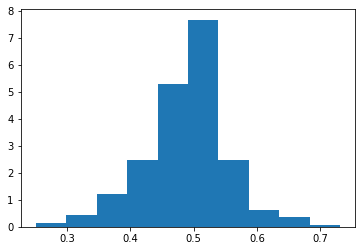

In [ ]:
#check the overlap conditions using randomForest
#get the propensity score function
g1_SH = treatment_k_fold_fit_and_predict(make_gmodel_randomForest, X=confounders_with_mediatorStudyHours, A=treatment, n_splits=10)
hist(g1_SH, density=True)

(array([0.04662222, 0.16317775, 0.34966662, 1.70171086, 3.79971056,
        5.82777693, 7.10988785, 3.98619942, 1.39866646, 0.16317775]),
 array([0.24580664, 0.28654548, 0.32728433, 0.36802317, 0.40876202,
        0.44950086, 0.49023971, 0.53097855, 0.5717174 , 0.61245625,
        0.65319509]),
 <a list of 10 Patch objects>)

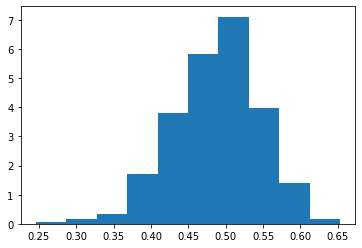

In [ ]:
#check the overlap conditions using Logistic Regression
g2_SH = treatment_k_fold_fit_and_predict(make_gmodel_logisticRegression, X=confounders_with_mediatorStudyHours, A=treatment, n_splits=10)
hist(g2_SH, density=True)

(array([0.09185222, 0.19518597, 0.47074263, 1.10222664, 1.99778578,
        3.42149518, 3.23779074, 1.06778205, 0.29851971, 0.20666749]),
 array([0.03295292, 0.11566557, 0.19837823, 0.28109088, 0.36380354,
        0.44651619, 0.52922885, 0.6119415 , 0.69465416, 0.77736681,
        0.86007947]),
 <a list of 10 Patch objects>)

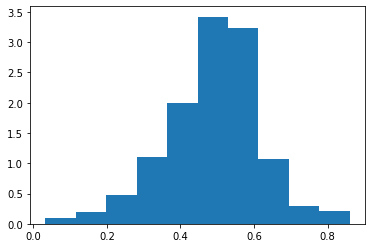

In [ ]:
#check the ovrlap conditions using XGBoost
g3_SH = treatment_k_fold_fit_and_predict(make_gmodel_XGBClassifier, X=confounders_with_mediatorStudyHours, A=treatment, n_splits=10)
hist(g3_SH, density=True)

## Calculate Natural Direct Effect using RandomForest: Using StudyHours as the mediator

### Calculate Q0 and Q1 model using Random Forest

In [ ]:
# Calculate Q0 and Q1 model
Q0_RFSH,Q1_RFSH = outcome_k_fold_fit_and_predict(make_Qmodel_randomForest, X=confounders_with_mediatorStudyHours, y=outcome, A=treatment, n_splits=10, output_type="continuous")

### Combine the Dataset for g, Q0, Q1, A, and Y values

In [ ]:
data_and_nuisance_estimates_RFSH = pd.DataFrame({'g': g1_SH, 'Q0': Q0_RFSH, 'Q1': Q1_RFSH, 'A': treatment, 'Y': outcome})
data_and_nuisance_estimates_RFSH.head()

,g,Q0,Q1,A,Y
0,0.489775,67.431700,65.706343,1,66.00
1,0.343330,76.630966,69.089733,0,80.50
2,0.401322,60.296567,61.397533,1,51.00
3,0.533141,64.638113,66.967111,0,86.00
4,0.508829,69.261842,71.032325,1,73.75


### Calculate the Natural Direct Effect using the ATU formula

In [ ]:
tau_hat_RFSH, std_hat_RFSH = att_aiptw(**data_and_nuisance_estimates_RFSH)
print(f"The estimate is {tau_hat_RFSH} pm {1.96*std_hat_RFSH}")

The estimate is -2.753633128300834 pm 1.5496175788538584


## Calculate Natural Direct Effect using Logistic Regression: Using StudyHours as the mediator

### Calculate Q0 and Q1 model using Logistic Regression

In [ ]:
Q0_LRSH,Q1_LRSH = outcome_k_fold_fit_and_predict(make_Qmodel_linearRegression, X=confounders_with_mediatorStudyHours, y=outcome, A=treatment, n_splits=10, output_type="continuous")

### Combine the dataset for g, Q0, Q1, A, and Y values

In [ ]:
data_and_nuisance_estimates_LRSH = pd.DataFrame({'g': g2_SH, 'Q0': Q0_LRSH, 'Q1': Q1_LRSH, 'A': treatment, 'Y': outcome})
data_and_nuisance_estimates_LRSH.head()

,g,Q0,Q1,A,Y
0,0.533715,70.974082,69.425775,1,66.00
1,0.332017,70.594631,68.621303,0,80.50
2,0.603007,68.384521,66.447611,1,51.00
3,0.512951,73.514182,71.577272,0,86.00
4,0.578292,69.038052,67.371191,1,73.75


### Calculate the Natural Direct Effect using the ATU formula

In [ ]:
tau_hat_LRSH, std_hat_LRSH = att_aiptw(**data_and_nuisance_estimates_LRSH)
print(f"The estimate is {tau_hat_LRSH} pm {1.96*std_hat_LRSH}")

The estimate is -1.8343752142951477 pm 1.4445238151981015


## Calculate the Natural Direct Effect using XGBoost model: Using StudyHours as the Mediator

### Calculate Q0 and Q1 model using XGBoost

In [ ]:
Q0_XGSH,Q1_XGSH = outcome_k_fold_fit_and_predict(make_Qmodel_XGBoost, X=confounders_with_mediatorStudyHours, y=outcome, A=treatment, n_splits=10, output_type="continuous")

### Combine the dataset for g, Q0, Q1, A, and Y values

In [ ]:
data_and_nuisance_estimates_XGSH = pd.DataFrame({'g': g3_SH, 'Q0': Q0_XGSH, 'Q1': Q1_XGSH, 'A': treatment, 'Y': outcome})
data_and_nuisance_estimates_XGSH.head()

,g,Q0,Q1,A,Y
0,0.482293,67.841805,67.810905,1,66.00
1,0.146785,67.763863,66.129585,0,80.50
2,0.166255,65.633568,65.620293,1,51.00
3,0.574701,70.896973,70.704071,0,86.00
4,0.488096,69.082649,66.766266,1,73.75


### Calculate the Natural Direct Effect using the ATU formula

In [ ]:
tau_hat_XGSH, std_hat_XGSH = att_aiptw(**data_and_nuisance_estimates_XGSH)
print(f"The estimate is {tau_hat_XGSH} pm {1.96*std_hat_XGSH}")

The estimate is -2.927115250206647 pm 1.9565777681092262


# Natural Direct Effect with Study Habits as the mediator

## Check Overlap Conditions 0<Pr(A =1 |𝐗 = x, M2 = m2) < 1 using the three models

(array([0.03684575, 0.11053726, 0.33161178, 1.08694973, 1.56594452,
        5.84005191, 7.44284219, 2.08178507, 0.60795493, 0.29476603]),
 array([0.17911342, 0.2306617 , 0.28220998, 0.33375826, 0.38530654,
        0.43685482, 0.4884031 , 0.53995138, 0.59149966, 0.64304794,
        0.69459622]),
 <a list of 10 Patch objects>)

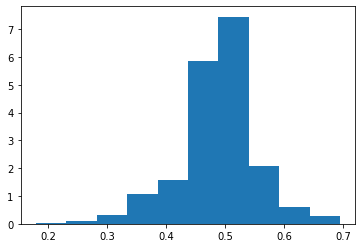

In [ ]:
#check the overlap conditions using randomForest
#get the propensity score function
g1_SB = treatment_k_fold_fit_and_predict(make_gmodel_randomForest, X=confounders_with_mediatorStudyHabits, 
                                      A=treatment, n_splits=10)
hist(g1_SB, density=True)

(array([0.02226187, 0.17809497, 0.97952232, 3.04987633, 5.69903897,
        6.94570375, 4.18523175, 1.80321155, 0.46749929, 0.11130935]),
 array([0.26484702, 0.30750595, 0.35016488, 0.39282381, 0.43548274,
        0.47814167, 0.5208006 , 0.56345953, 0.60611847, 0.6487774 ,
        0.69143633]),
 <a list of 10 Patch objects>)

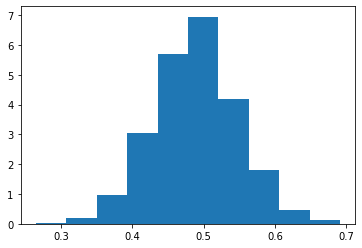

In [ ]:
g2_SB = treatment_k_fold_fit_and_predict(make_gmodel_logisticRegression, X=confounders_with_mediatorStudyHabits, 
                                      A=treatment, n_splits=10)
hist(g2_SB, density=True)

(array([0.07726504, 0.19868154, 0.58500676, 0.99340771, 2.64908724,
        4.26061531, 1.74398243, 0.67330967, 0.32009804, 0.1214165 ]),
 array([0.03839169, 0.12442896, 0.21046623, 0.2965035 , 0.38254077,
        0.46857803, 0.5546153 , 0.64065257, 0.72668984, 0.8127271 ,
        0.89876437]),
 <a list of 10 Patch objects>)

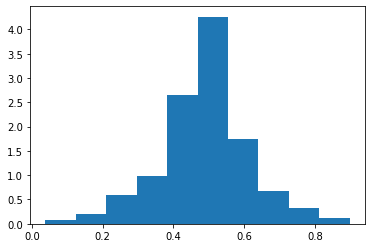

In [ ]:
g3_SB = treatment_k_fold_fit_and_predict(make_gmodel_XGBClassifier, X=confounders_with_mediatorStudyHabits, 
                                      A=treatment, n_splits=10)
hist(g3_SB, density=True)

## Calculate Natural Direct Effect using RandomForest: Using Study Habits as the mediator

### Calculate Q0 and Q1 model using RandomForest

In [ ]:
Q0_RFSB,Q1_RFSB = outcome_k_fold_fit_and_predict(make_Qmodel_randomForest, 
                                             X=confounders_with_mediatorStudyHabits, y=outcome, 
                                             A=treatment, n_splits=10, output_type="continuous")

### Combine the Dataset for g, Q0, Q1, A, and Y values

In [ ]:
data_and_nuisance_estimates_RFSB = pd.DataFrame({'g': g1_SB, 'Q0': Q0_RFSB, 'Q1': Q1_RFSB, 'A': treatment, 'Y': outcome})
data_and_nuisance_estimates_RFSB.head()

,g,Q0,Q1,A,Y
0,0.500123,66.150933,62.072200,1,66.00
1,0.266431,74.214466,63.715450,0,80.50
2,0.343274,65.062633,65.714166,1,51.00
3,0.554137,65.159133,75.497333,0,86.00
4,0.462771,70.145234,67.461267,1,73.75


### Calculate the Natural Direct Effect using the ATU formula

In [ ]:
tau_hat_RFSB, std_hat_RFSB = att_aiptw(**data_and_nuisance_estimates_RFSB)
print(f"The estimate using RandomForest is {tau_hat_RFSB} pm {1.96*std_hat_RFSB}")

The estimate using RandomForest is -2.5908460215675917 pm 1.6171737477043109


## Calculate Natural Direct Effect using LogisticRegression: Using Study Habits as the mediator

### Calculate Q0 and Q1 model using Logistic Regression

In [ ]:
Q0_LRSB,Q1_LRSB = outcome_k_fold_fit_and_predict(make_Qmodel_linearRegression, 
                                             X=confounders_with_mediatorStudyHabits, y=outcome, 
                                             A=treatment, n_splits=10, output_type="continuous")

### Combine the Dataset for g, Q0, Q1, A, and Y values

In [ ]:
data_and_nuisance_estimates_LRSB = pd.DataFrame({'g': g2_SB, 'Q0': Q0_LRSB, 'Q1': Q1_LRSB, 'A': treatment, 'Y': outcome})
data_and_nuisance_estimates_LRSB.head()

,g,Q0,Q1,A,Y
0,0.538715,72.583799,70.812289,1,66.00
1,0.316658,71.202679,68.928732,0,80.50
2,0.529020,70.081987,67.947324,1,51.00
3,0.525366,73.869333,71.734670,0,86.00
4,0.526407,69.989148,68.083762,1,73.75


### Calculate the Natural Direct Effect using the ATU formula

In [ ]:
tau_hat_LRSB, std_hat_LRSB = att_aiptw(**data_and_nuisance_estimates_LRSB)
print(f"The estimate using LogisticRegression is {tau_hat_LRSB} pm {1.96*std_hat_LRSB}")

The estimate using LogisticRegression is -2.0192248304466696 pm 1.4625396821624506


## Calculate Natural Direct Effect using XGBoost: Using Study Habits as the mediator

### Calculate Q0 and Q1 model using XGBoost

In [ ]:
Q0_XGSB,Q1_XGSB = outcome_k_fold_fit_and_predict(make_Qmodel_XGBoost, 
                                             X=confounders_with_mediatorStudyHabits, y=outcome, 
                                             A=treatment, n_splits=10, output_type="continuous")

### Combine the Dataset for g, Q0, Q1, A, and Y values

In [ ]:
data_and_nuisance_estimates_XGSB = pd.DataFrame({'g': g3_SB, 'Q0': Q0_XGSB, 'Q1': Q1_XGSB, 'A': treatment, 'Y': outcome})
data_and_nuisance_estimates_XGSB.head()

,g,Q0,Q1,A,Y
0,0.540272,70.324379,69.677727,1,66.00
1,0.235503,68.845772,66.447899,0,80.50
2,0.057033,64.033539,63.100536,1,51.00
3,0.586557,72.397858,71.773628,0,86.00
4,0.480623,70.607597,68.406670,1,73.75


### Calculate the Natural Direct Effect using the ATU formula

In [ ]:
tau_hat_XGSB, std_hat_XGSB = att_aiptw(**data_and_nuisance_estimates_XGSB)
print(f"The estimate using XGBoost is {tau_hat_XGSB} pm {1.96*std_hat_XGSB}")

The estimate using XGBoost is -3.354606172287593 pm 1.993589478959646


# Estimate the Total Effect using ATE

(array([0.12961852, 0.1008144 , 0.38885556, 1.03694816, 3.57171033,
        5.48718402, 3.57171033, 0.47526791, 0.36005145, 0.04320617]),
 array([0.1371038 , 0.20304352, 0.26898324, 0.33492295, 0.40086267,
        0.46680239, 0.53274211, 0.59868182, 0.66462154, 0.73056126,
        0.79650097]),
 <a list of 10 Patch objects>)

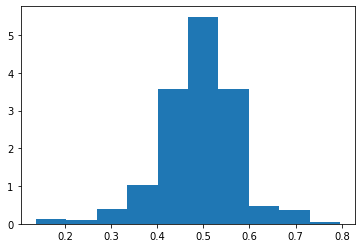

In [ ]:
#check the overlap conditions using randomForest
#get the propensity score function
g1_TE = treatment_k_fold_fit_and_predict(make_gmodel_randomForest, X=confounders_without_Mediator, 
                                      A=treatment, n_splits=10)
hist(g1_TE, density=True)

(array([ 0.43207328,  0.56169527,  4.36394014,  5.44412334,  3.62941556,
         6.65392853, 17.02368728,  5.66015998,  1.55546381,  0.17282931]),
 array([0.36608062, 0.38805994, 0.41003926, 0.43201858, 0.4539979 ,
        0.47597721, 0.49795653, 0.51993585, 0.54191517, 0.56389449,
        0.58587381]),
 <a list of 10 Patch objects>)

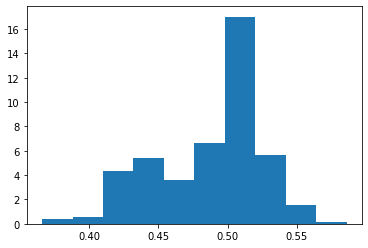

In [ ]:
g2_TE = treatment_k_fold_fit_and_predict(make_gmodel_logisticRegression, X=confounders_without_Mediator, 
                                      A=treatment, n_splits=10)
hist(g2_TE, density=True)

(array([0.05351569, 0.13378922, 0.44150441, 1.7392598 , 4.77627499,
        4.25449705, 1.72588088, 0.52177794, 0.32109412, 0.12041029]),
 array([0.12827121, 0.19925358, 0.27023596, 0.34121833, 0.4122007 ,
        0.48318308, 0.55416545, 0.62514783, 0.6961302 , 0.76711258,
        0.83809495]),
 <a list of 10 Patch objects>)

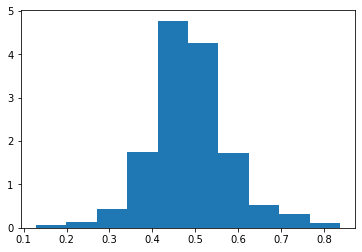

In [ ]:
g3_TE = treatment_k_fold_fit_and_predict(make_gmodel_XGBClassifier, X=confounders_without_Mediator, 
                                      A=treatment, n_splits=10)
hist(g3_TE, density=True)

### Calculate Total Effect using RandomForest

In [ ]:
Q0_RFTE,Q1_RFTE = outcome_k_fold_fit_and_predict(make_Qmodel_randomForest, 
                                             X=confounders_without_Mediator, y=outcome, 
                                             A=treatment, n_splits=10, output_type="continuous")

In [ ]:
data_and_nuisance_estimates_RFTE = pd.DataFrame({'g': g1_TE, 'Q0': Q0_RFTE, 'Q1': Q1_RFTE, 'A': treatment, 'Y': outcome})
data_and_nuisance_estimates_RFTE.head()

,g,Q0,Q1,A,Y
0,0.438536,72.579543,68.840605,1,66.00
1,0.343346,67.703109,64.738599,0,80.50
2,0.581339,60.319673,67.761543,1,51.00
3,0.551200,71.961191,69.498636,0,86.00
4,0.469994,69.500194,69.771343,1,73.75


In [ ]:
tau_hat_RFTE, std_hat_RFTE = att_aiptw(**data_and_nuisance_estimates_RFTE)
print(f"The estimate using RandomForest is {tau_hat_RFTE} pm {1.96*std_hat_RFTE}")

The estimate using RandomForest is -1.7790772656513485 pm 1.5776206659099865


### Calculate Total Effect using Logistic Regression

In [ ]:
Q0_LRTE,Q1_LRTE = outcome_k_fold_fit_and_predict(make_Qmodel_linearRegression, 
                                             X=confounders_without_Mediator, y=outcome, 
                                             A=treatment, n_splits=10, output_type="continuous")

In [ ]:
data_and_nuisance_estimates_LRTE = pd.DataFrame({'g': g2_TE, 'Q0': Q0_LRTE, 'Q1': Q1_LRTE, 'A': treatment, 'Y': outcome})
data_and_nuisance_estimates_LRTE.head()

,g,Q0,Q1,A,Y
0,0.508915,70.716623,68.827844,1,66.00
1,0.426388,68.513316,66.139839,0,80.50
2,0.549834,72.131155,69.763695,1,51.00
3,0.513280,72.229304,69.861845,0,86.00
4,0.528771,72.567820,70.505118,1,73.75


In [ ]:
tau_hat_LRTE, std_hat_LRTE = att_aiptw(**data_and_nuisance_estimates_LRTE)
print(f"The estimate using Logistic Regression is {tau_hat_LRTE} pm {1.96*std_hat_LRTE}")

The estimate using Logistic Regression is -2.1223541374303023 pm 1.4645467188074133


### Calculate Total Effect using XGBoost

In [ ]:
Q0_XGTE,Q1_XGTE = outcome_k_fold_fit_and_predict(make_Qmodel_XGBoost, 
                                             X=confounders_without_Mediator, y=outcome, 
                                             A=treatment, n_splits=10, output_type="continuous")

In [ ]:
data_and_nuisance_estimates_XGTE = pd.DataFrame({'g': g3_TE, 'Q0': Q0_XGTE, 'Q1': Q1_XGTE, 'A': treatment, 'Y': outcome})
data_and_nuisance_estimates_XGTE.head()

,g,Q0,Q1,A,Y
0,0.469214,70.609489,69.098419,1,66.00
1,0.318217,68.393028,65.903877,0,80.50
2,0.655463,65.565598,70.034653,1,51.00
3,0.555799,72.044601,70.039925,0,86.00
4,0.453036,70.281975,69.515648,1,73.75


In [ ]:
tau_hat_XGTE, std_hat_XGTE = att_aiptw(**data_and_nuisance_estimates_XGTE)
print(f"The estimate using XGBoost is {tau_hat_XGTE} pm {1.96*std_hat_XGTE}")

The estimate using XGBoost is -1.8219769446077165 pm 1.5872902512960967


# Placebo Effect

(array([0.02309415, 0.01154708, 0.03464123, 0.21939447, 1.02768989,
        8.41781945, 1.38564929, 0.45033602, 0.53116556, 0.05773539]),
 array([0.0944689 , 0.17671201, 0.25895513, 0.34119824, 0.42344136,
        0.50568447, 0.58792759, 0.6701707 , 0.75241382, 0.83465693,
        0.91690005]),
 <a list of 10 Patch objects>)

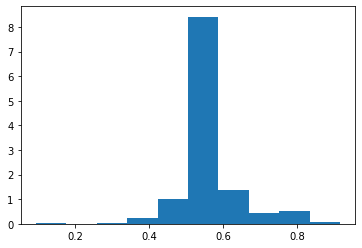

In [ ]:
#check the overlap conditions using randomForest
#get the propensity score function
g1_P = treatment_k_fold_fit_and_predict(make_gmodel_randomForest, X=confounders_without_Mediator, 
                                      A=placebo, n_splits=10)
hist(g1_P, density=True)

(array([ 1.17145342,  5.98057801, 17.94173404, 16.58531428,  2.95946128,
         2.34290685,  8.26182942,  4.99409092,  3.20608306,  1.47973064]),
 array([0.49316377, 0.50856659, 0.52396941, 0.53937223, 0.55477505,
        0.57017786, 0.58558068, 0.6009835 , 0.61638632, 0.63178914,
        0.64719196]),
 <a list of 10 Patch objects>)

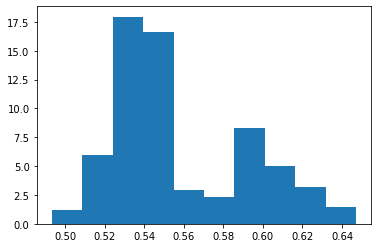

In [ ]:
g2_P = treatment_k_fold_fit_and_predict(make_gmodel_logisticRegression, X=confounders_without_Mediator, 
                                      A=placebo, n_splits=10)
hist(g2_P, density=True)

(array([0.01203172, 0.03609515, 0.19250749, 0.39704669, 1.16707663,
        8.0853144 , 1.31145725, 0.84222025, 0.51736387, 0.10828546]),
 array([0.11759996, 0.1965303 , 0.27546064, 0.35439099, 0.43332133,
        0.51225167, 0.59118201, 0.67011236, 0.7490427 , 0.82797304,
        0.90690339]),
 <a list of 10 Patch objects>)

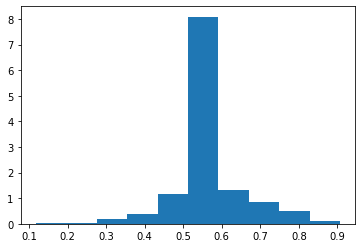

In [ ]:
g3_P = treatment_k_fold_fit_and_predict(make_gmodel_XGBClassifier, X=confounders_without_Mediator, 
                                      A=placebo, n_splits=10)
hist(g3_P, density=True)

### Calculate Placebo Effect using RandomForest

In [ ]:
Q0_RF_P,Q1_RF_P = outcome_k_fold_fit_and_predict(make_Qmodel_randomForest, 
                                             X=confounders_without_Mediator, y=outcome, 
                                             A=placebo, n_splits=10, output_type="continuous")

In [ ]:
data_and_nuisance_estimates_RF_P = pd.DataFrame({'g': g1_P, 'Q0': Q0_RF_P, 'Q1': Q1_RF_P, 'A': placebo, 'Y': outcome})
data_and_nuisance_estimates_RF_P.head()

,g,Q0,Q1,A,Y
0,0.481598,72.340846,70.939883,1,66.00
1,0.646032,58.603514,70.503972,0,80.50
2,0.565808,64.468681,66.184606,1,51.00
3,0.536289,69.780506,71.255966,1,86.00
4,0.557673,69.251195,69.868593,1,73.75


In [ ]:
tau_hat_RF_P, std_hat_RF_P = att_aiptw(**data_and_nuisance_estimates_RF_P)
print(f"The estimate using RandomForest is {tau_hat_RF_P} pm {1.96*std_hat_RF_P}")

The estimate using RandomForest is 0.40805422360499 pm 1.6173649585760044


### Calculate Total Effect using Logistic Regression

In [ ]:
Q0_LR_P,Q1_LR_P = outcome_k_fold_fit_and_predict(make_Qmodel_linearRegression, 
                                             X=confounders_without_Mediator, y=outcome, 
                                             A=placebo, n_splits=10, output_type="continuous")

In [ ]:
data_and_nuisance_estimates_LR_P = pd.DataFrame({'g': g2_P, 'Q0': Q0_LR_P, 'Q1': Q1_LR_P, 'A': placebo, 'Y': outcome})
data_and_nuisance_estimates_LR_P.head()

,g,Q0,Q1,A,Y
0,0.551877,69.524717,69.934172,1,66.00
1,0.626369,67.208874,67.637607,0,80.50
2,0.533274,70.683329,70.810829,1,51.00
3,0.536234,70.939209,71.066709,1,86.00
4,0.528450,71.385973,71.593587,1,73.75


In [ ]:
tau_hat_LR_P, std_hat_LR_P = att_aiptw(**data_and_nuisance_estimates_LR_P)
print(f"The estimate using Logistic Regression is {tau_hat_LR_P} pm {1.96*std_hat_LR_P}")

The estimate using Logistic Regression is 0.40061233433516324 pm 1.4943580764853726


### Calculate Total Effect using XGBoost

In [ ]:
Q0_XG_P,Q1_XG_P = outcome_k_fold_fit_and_predict(make_Qmodel_XGBoost, 
                                             X=confounders_without_Mediator, y=outcome, 
                                             A=placebo, n_splits=10, output_type="continuous")

In [ ]:
data_and_nuisance_estimates_XG_P = pd.DataFrame({'g': g3_P, 'Q0': Q0_XG_P, 'Q1': Q1_XG_P, 'A': placebo, 'Y': outcome})
data_and_nuisance_estimates_XG_P.head()

,g,Q0,Q1,A,Y
0,0.467969,68.617706,70.990387,1,66.00
1,0.657462,67.056839,67.987701,0,80.50
2,0.542084,67.061264,69.180847,1,51.00
3,0.528515,71.055573,70.652328,1,86.00
4,0.561163,70.482674,70.403893,1,73.75


In [ ]:
tau_hat_XG_P, std_hat_XG_P = att_aiptw(**data_and_nuisance_estimates_XG_P)
print(f"The estimate using XGBoost is {tau_hat_XG_P} pm {1.96*std_hat_XG_P}")

The estimate using XGBoost is 0.45382060209819086 pm 1.5795423653698881


# The table of results

In [ ]:
NDE_table = [['Outcome','Type of causal effect','Mediator excluded', 'Model', 'Estimate','p/m', 'Standard Error'], 
         ['Fall_grade','Natural Direct Effect', 'Study Hours', 'RandomForest',tau_hat_RFSH,1.96*std_hat_RFSH, std_hat_RFSH], 
         ['Fall_grade','Natural Direct Effect', 'Study Hours', 'Logistic Regression',tau_hat_LRSH,1.96*std_hat_LRSH,std_hat_LRSH],
         ['Fall_grade','Natural Direct Effect', 'Study Hours', 'XGBoost',tau_hat_XGSH,1.96*std_hat_XGSH,std_hat_XGSH],
         ['Fall_grade','Natural Direct Effect', 'Study Habits', 'RandomForest',tau_hat_RFSB,1.96*std_hat_RFSB,std_hat_RFSB], 
         ['Fall_grade','Natural Direct Effect', 'Study Habits', 'Logistic Regression',tau_hat_LRSB,1.96*std_hat_LRSB,std_hat_LRSB],
         ['Fall_grade','Natural Direct Effect', 'Study Habits', 'XGBoost',tau_hat_XGSB,1.96*std_hat_XGSB,std_hat_XGSB],
         ['Fall_grade','Natural Direct Effect', 'Study Hours and Study Habits', 'RandomForest',tau_hat_RF,1.96*std_hat_RF,std_hat_RF], 
         ['Fall_grade','Natural Direct Effect', 'Study Hours and Study Habits', 'Logistic Regression',tau_hat_LR,1.96*std_hat_LR,std_hat_LR],
         ['Fall_grade','Natural Direct Effect', 'Study Hours and Study Habits', 'XGBoost',tau_hat_XGB,1.96*std_hat_XGB,std_hat_XGB]]

In [ ]:
TE_table = [['Outcome','Type of causal effect', 'Model', 'Estimate','p/m', 'Standard Error'],
            ['Fall_grade','Total Effect', 'RandomForest',tau_hat_RFTE,1.96*std_hat_RFTE, std_hat_RFTE], 
            ['Fall_grade','Total Effect', 'Logistic Regression',tau_hat_LRTE,1.96*std_hat_LRTE, std_hat_LRTE],
            ['Fall_grade','Total Effect', 'XGBoost',tau_hat_XGTE,1.96*std_hat_XGTE, std_hat_XGTE]]

In [ ]:
Plb_table = [['Outcome','Type of causal effect', 'Model', 'Estimate','p/m', 'Standard Error'],
                 ['Fall_grade','Placebo Effect on Agreealeness', 'RandomForest',tau_hat_RF_P,1.96*std_hat_RF_P,std_hat_RF_P], 
                 ['Fall_grade','Placebo Effect on Agreealeness', 'Logistic Regression',tau_hat_LR_P,1.96*std_hat_LR_P,std_hat_LR_P],
                 ['Fall_grade','Placebo Effect on Agreealeness', 'XGBoost',tau_hat_XG_P,1.96*std_hat_XG_P,std_hat_XG_P]]

In [ ]:
df_NDE = pd.DataFrame(NDE_table)
df_NDE.columns = df_NDE.iloc[0]
df_NDE = df_NDE[1:]
df_NDE

,Outcome,Type of causal effect,Mediator excluded,Model,Estimate,p/m,Standard Error
1,Fall_grade,Natural Direct Effect,Study Hours,RandomForest,-2.753633,1.549618,0.790621
2,Fall_grade,Natural Direct Effect,Study Hours,Logistic Regression,-1.834375,1.444524,0.737002
3,Fall_grade,Natural Direct Effect,Study Hours,XGBoost,-2.927115,1.956578,0.998254
4,Fall_grade,Natural Direct Effect,Study Habits,RandomForest,-2.590846,1.617174,0.825089
5,Fall_grade,Natural Direct Effect,Study Habits,Logistic Regression,-2.019225,1.46254,0.746194
6,Fall_grade,Natural Direct Effect,Study Habits,XGBoost,-3.354606,1.993589,1.017137
7,Fall_grade,Natural Direct Effect,Study Hours and Study Habits,RandomForest,-2.638443,1.527729,0.779454
8,Fall_grade,Natural Direct Effect,Study Hours and Study Habits,Logistic Regression,-1.892744,1.462806,0.746329
9,Fall_grade,Natural Direct Effect,Study Hours and Study Habits,XGBoost,-3.018747,1.965744,1.002931


In [ ]:
df_TE = pd.DataFrame(TE_table)
df_TE.columns = df_TE.iloc[0]
df_TE = df_TE[1:]
df_TE

,Outcome,Type of causal effect,Model,Estimate,p/m,Standard Error
1,Fall_grade,Total Effect,RandomForest,-1.779077,1.577621,0.804909
2,Fall_grade,Total Effect,Logistic Regression,-2.122354,1.464547,0.747218
3,Fall_grade,Total Effect,XGBoost,-1.821977,1.58729,0.809842


In [ ]:
df_plb = pd.DataFrame(Plb_table)
df_plb.columns = df_plb.iloc[0]
df_plb = df_plb[1:]
df_plb

,Outcome,Type of causal effect,Model,Estimate,p/m,Standard Error
1,Fall_grade,Placebo Effect on Agreealeness,RandomForest,0.408054,1.617365,0.825186
2,Fall_grade,Placebo Effect on Agreealeness,Logistic Regression,0.400612,1.494358,0.762428
3,Fall_grade,Placebo Effect on Agreealeness,XGBoost,0.453821,1.579542,0.805889


### Table of Sanity checks results 

In [ ]:
San_table = [['Outcome','Model','Mediators','Q model MSE','Q model baseline','g model CE','g model baseline'], 
         ['Fall_grade','RandomForest','none', test_mse_RF0,baseline_mse_RF0,test_ce_RF0,baseline_ce_RF0], 
         ['Fall_grade','RandomForest','both', test_mse_RF2,baseline_mse_RF2,test_ce_RF2,baseline_ce_RF2],
         ['Fall_grade','RandomForest','Study Hours', test_mse_RFSH,baseline_mse_RFSH,test_ce_RFSH,baseline_ce_RFSH],
         ['Fall_grade','RandomForest','Study Habits', test_mse_RFSB,baseline_mse_RFSB,test_ce_RFSB,baseline_ce_RFSB],
         ['Fall_grade','Logistic Regression','none', test_mse_LR0,baseline_mse_LR0,test_ce_LR0,baseline_ce_LR0], 
         ['Fall_grade','Logistic Regression','both', test_mse_LR2,baseline_mse_LR2,test_ce_LR2,baseline_ce_LR2],
         ['Fall_grade','Logistic Regression','Study Hours', test_mse_LRSH,baseline_mse_LRSH,test_ce_LRSH,baseline_ce_LRSH],
         ['Fall_grade','Logistic Regression','Study Habits', test_mse_LRSB,baseline_mse_LRSB,test_ce_LRSB,baseline_ce_LRSB],
         ['Fall_grade','XGBoost','none', test_mse_XG0,baseline_mse_XG0,test_ce_XG0,baseline_ce_XG0], 
         ['Fall_grade','XGBoost','both', test_mse_XG2,baseline_mse_LR2,test_ce_XG2,baseline_ce_XG2],
         ['Fall_grade','XGBoost','Study Hours', test_mse_XGSH,baseline_mse_XGSH,test_ce_XGSH,baseline_ce_XGSH],
         ['Fall_grade','XGBoost','Study Habits', test_mse_XGSB,baseline_mse_LRSB,test_ce_XGSB,baseline_ce_XGSB]]

In [ ]:
df_san = pd.DataFrame(San_table)
df_san.columns = df_san.iloc[0]
df_san = df_san[1:]
df_san

,Outcome,Model,Mediators,Q model MSE,Q model baseline,g model CE,g model baseline
1,Fall_grade,RandomForest,none,144.602557,132.340968,0.701371,0.693147
2,Fall_grade,RandomForest,both,151.765518,138.77815,0.707038,0.693147
3,Fall_grade,RandomForest,Study Hours,165.085445,163.854262,0.69526,0.693771
4,Fall_grade,RandomForest,Study Habits,157.891266,140.984591,0.69,0.692419
5,Fall_grade,Logistic Regression,none,128.835202,129.303117,0.685745,0.692866
6,Fall_grade,Logistic Regression,both,146.292141,158.282511,0.704775,0.692373
7,Fall_grade,Logistic Regression,Study Hours,142.288205,149.319232,0.687294,0.693418
8,Fall_grade,Logistic Regression,Study Habits,144.783121,148.984011,0.681076,0.692371
9,Fall_grade,XGBoost,none,146.840556,142.851953,0.716614,0.695686
10,Fall_grade,XGBoost,both,136.071044,158.282511,0.742539,0.696292


## Table of Natural Indirect Effect

In [ ]:
NIE_table = [['Outcome','Type of causal effect','Through which Mediator', 'Model', 'Estimate'], 
         ['Fall_grade','Natural Indirect Direct Effect', 'Study Hours', 'RandomForest',tau_hat_RFTE - tau_hat_RFSH], 
         ['Fall_grade','Natural Indirect Direct Effect', 'Study Hours', 'Logistic Regression',tau_hat_LRTE - tau_hat_LRSH],
         ['Fall_grade','Natural Indirect Direct Effect', 'Study Hours', 'XGBoost',tau_hat_XGTE - tau_hat_XGSH],
         ['Fall_grade','Natural Indirect Direct Effect', 'Study Habits', 'RandomForest',tau_hat_RFTE - tau_hat_RFSB], 
         ['Fall_grade','Natural Indirect Direct Effect', 'Study Habits', 'Logistic Regression',tau_hat_LRTE - tau_hat_LRSB],
         ['Fall_grade','Natural Indirect Direct Effect', 'Study Habits', 'XGBoost',tau_hat_XGTE - tau_hat_XGSB]]

In [ ]:
df_NIE = pd.DataFrame(NIE_table)
df_NIE.columns = df_NIE.iloc[0]
df_NIE = df_NIE[1:]
df_NIE

,Outcome,Type of causal effect,Through which Mediator,Model,Estimate
1,Fall_grade,Natural Indirect Direct Effect,Study Hours,RandomForest,0.974556
2,Fall_grade,Natural Indirect Direct Effect,Study Hours,Logistic Regression,-0.287979
3,Fall_grade,Natural Indirect Direct Effect,Study Hours,XGBoost,1.105138
4,Fall_grade,Natural Indirect Direct Effect,Study Habits,RandomForest,0.811769
5,Fall_grade,Natural Indirect Direct Effect,Study Habits,Logistic Regression,-0.103129
6,Fall_grade,Natural Indirect Direct Effect,Study Habits,XGBoost,1.532629
